In [165]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [166]:
with open("/home/akita/autolab/DUET/saves/C0_09", "rb") as f:
    data = np.load(f)
data=data[43:]
tmp = pd.read_csv("/home/akita/autolab/DUET/datafiles/IMG_4015.dat", delimiter='\t').to_numpy(dtype=np.float)
# tmp=tmp[200:]
traj = []
for i in np.arange(0, len(tmp), len(tmp)/len(data)):
    traj.append(tmp[(int)(i)])
traj = np.array(traj)
print(traj.shape)

(2211, 25)


In [167]:
all_frames = {}
for index, (human, robot) in enumerate(zip(data, traj)):
    body_dict={}
    robot_dict=[robot[i+1] for i in range(6)]
    for i in range(9):
        x = human[i*2]
        y = human[i*2+1]
        body_dict[i] = (x, y)
    hands = human[48:48+85]
    hand = np.array([0,0], dtype='float64')
    for i in [4, 8, 16, 20]:
        hand += np.array([hands[i*4], hands[i*4+1]])
    body_dict[9] = tuple(hand/4)

    hand = np.array([0,0], dtype='float64')
    for i in [4, 8, 16, 20]:
        hand += np.array([hands[i*4+2], hands[i*4+3]])
    body_dict[10] = tuple(hand/4)

    all_frames[index] = (body_dict, robot_dict)

print(all_frames[0])

({0: (1154.52, 924.988), 1: (1189.67, 1107.46), 2: (1054.3, 1113.36), 3: (1013.54, 1343.09), 4: (1001.56, 1537.28), 5: (1313.48, 1101.77), 6: (1348.75, 1336.89), 7: (1354.87, 1531.58), 8: (1189.72, 1490.25), 9: (1005.7335, 1675.1775), 10: (1372.145, 1666.035)}, [3.1415900000000003, -0.2317, -0.08135, -0.07603, 1.5708, -1.52049])


In [168]:
import urdfpy
from urdfpy import URDF

def compute_fk(robot, angle_arr):
    robot_dict = {i:joint for i, joint in enumerate(robot.actuated_joints)}
    fk = robot.link_fk(cfg={robot_dict[i]:angle for i, angle in enumerate(angle_arr)})
    return [fk[robot.links[i]] for i in range(8)]


In [169]:
robot = URDF.load("/home/akita/autolab/urdfpy/tests/data/ur5/ur5.urdf")

def animate(i):
    global fingers1
    global fingers2
    global gripper
    global trails
    
    frame_dict = all_frames[i][0]
    curr_trail = np.zeros(6)

    if not(frame_dict[1] == (0, 0) or frame_dict[2] == (0, 0)):
        x = np.linspace(frame_dict[1][0], frame_dict[2][0])
        y = np.linspace(frame_dict[1][1], frame_dict[2][1])
        shoulder1.set_data(x, y)

    if not(frame_dict[1] == (0, 0) or frame_dict[5] == (0, 0)):
        x = np.linspace(frame_dict[1][0], frame_dict[5][0])
        y = np.linspace(frame_dict[1][1], frame_dict[5][1])
        shoulder2.set_data(x, y)

    if not(frame_dict[2] == (0, 0) or frame_dict[3] == (0, 0)):
        x = np.linspace(frame_dict[2][0], frame_dict[3][0])
        y = np.linspace(frame_dict[2][1], frame_dict[3][1])
        elbow1.set_data(x, y)

    if not(frame_dict[5] == (0, 0) or frame_dict[6] == (0, 0)):
        x = np.linspace(frame_dict[5][0], frame_dict[6][0])
        y = np.linspace(frame_dict[5][1], frame_dict[6][1])
        elbow2.set_data(x, y)

    if not(frame_dict[3] == (0, 0) or frame_dict[4] == (0, 0)):
        x = np.linspace(frame_dict[3][0], frame_dict[4][0])
        y = np.linspace(frame_dict[3][1], frame_dict[4][1])
        wrist1.set_data(x, y)

    if not(frame_dict[6] == (0, 0) or frame_dict[7] == (0, 0)):
        x = np.linspace(frame_dict[6][0], frame_dict[7][0])
        y = np.linspace(frame_dict[6][1], frame_dict[7][1])
        wrist2.set_data(x, y)


    if not(frame_dict[4] == (0, 0) or frame_dict[9] == (0, 0)):
        hand1.set_data(np.linspace(frame_dict[4][0], frame_dict[9][0]),
                      np.linspace(frame_dict[4][1], frame_dict[9][1]))
        fingers1.remove()
        fingers1 = ax.scatter(frame_dict[9][0], frame_dict[9][1], c='green')

        curr_trail[0] = frame_dict[9][0]
        curr_trail[1] = frame_dict[9][1]
            

    if not(frame_dict[7] == (0, 0) or frame_dict[10] == (0, 0)):
        hand2.set_data(np.linspace(frame_dict[7][0], frame_dict[10][0]),
                      np.linspace(frame_dict[7][1], frame_dict[10][1]))
        fingers2.remove()
        fingers2 = ax.scatter(frame_dict[10][0], frame_dict[10][1], c='red')
        curr_trail[2] = frame_dict[10][0]
        curr_trail[3] = frame_dict[10][1]


    if not(frame_dict[1] == (0, 0) or frame_dict[8] == (0, 0)):
        x = np.linspace(frame_dict[1][0], frame_dict[8][0])
        y = np.linspace(frame_dict[1][1], frame_dict[8][1])
        chest.set_data(x, y)

    robot_pose = compute_fk(robot, all_frames[i][1])

    prev = np.array([0,0], dtype=float)
    jt = np.linspace(prev, robot_pose[0][0:3:2, 3:].T[0])
    segment0.set_data(jt[:,0], jt[:, 1])
    prev = jt[-1]
    
    jt = np.linspace(prev, robot_pose[1][0:3:2, 3:].T[0])
    segment1.set_data(jt[:,0], jt[:, 1])
    prev = jt[-1]

    jt = np.linspace(prev, robot_pose[2][0:3:2, 3:].T[0])
    segment2.set_data(jt[:,0], jt[:, 1])
    prev = jt[-1]

    jt = np.linspace(prev, robot_pose[3][0:3:2, 3:].T[0])
    segment3.set_data(jt[:,0], jt[:, 1])
    prev = jt[-1]

    jt = np.linspace(prev, robot_pose[4][0:3:2, 3:].T[0])
    segment4.set_data(jt[:,0], jt[:, 1])
    prev = jt[-1]

    jt = np.linspace(prev, robot_pose[5][0:3:2, 3:].T[0])
    segment5.set_data(jt[:,0], jt[:, 1])
    prev = jt[-1]

    jt = np.linspace(prev, robot_pose[6][0:3:2, 3:].T[0])
    segment6.set_data(jt[:,0], jt[:, 1])
    prev = jt[-1]

    gripper.remove()
    gripper = fax.scatter(prev[0], prev[1], c='blue')
    curr_trail[4] = prev[0]
    curr_trail[5] = prev[1]
    
    trails = np.vstack([trails, curr_trail])
    trail1.set_data(trails[1:].T[0], trails[1:].T[1])
    trail2.set_data(trails[1:].T[2], trails[1:].T[3])
    trail3.set_data(trails[1:].T[4], trails[1:].T[5])

    
    return shoulder1, shoulder2, neck, elbow1, elbow2, chest,\
        wrist1, wrist2, hand1, hand2, segment0, segment1,\
        segment2, segment3, segment4, segment5, segment6,\
        trail1, trail2, trail3


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


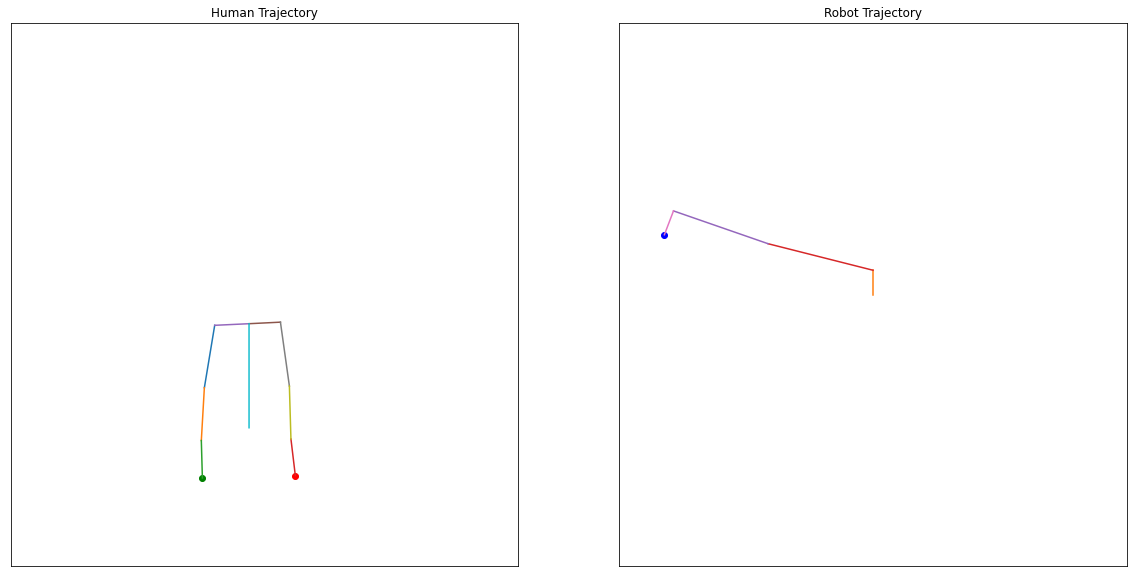

In [170]:
fig, (ax, fax) = plt.subplots(1, 2, figsize=(
    20, 10), sharex=False, sharey=False)
ax.set_ylim([0, 2000])
ax.set_xlim([250, 2250])

elbow1, = ax.plot([], [])
wrist1, = ax.plot([], [])
hand1, = ax.plot([], [])
hand2, = ax.plot([],[])
fingers1 = ax.scatter([],[])
fingers2 = ax.scatter([],[])
shoulder1, = ax.plot([], [])
shoulder2, = ax.plot([], [])
neck, = ax.plot([], [])

elbow2, = ax.plot([], [])
wrist2, = ax.plot([], [])
chest, = ax.plot([], [])
hip1, = ax.plot([], [])
hip2, = ax.plot([], [])
knee1, = ax.plot([], [])
knee2, = ax.plot([], [])
ankle1, = ax.plot([], [])
ankle2, = ax.plot([], [])

fax.set_ylim([-1, 1])
fax.set_xlim([-1, 1])
segment0, = fax.plot([],[])
segment1, = fax.plot([],[])
segment2, = fax.plot([],[])
segment3, = fax.plot([],[])
segment4, = fax.plot([],[])
segment5, = fax.plot([],[])
segment6, = fax.plot([],[])
gripper = fax.scatter([],[])

trail1, = ax.plot([],[],'--',c='green')
trail2, = ax.plot([],[],'--',c='red')
trail3, = fax.plot([],[],'--',c='blue')

trails = np.zeros(6)

fax.axes.xaxis.set_visible(False)
fax.axes.yaxis.set_visible(False)
fax.set_title("Robot Trajectory")

ax.invert_yaxis()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_title("Human Trajectory")


anim = FuncAnimation(
    fig,
    animate,
    frames=len(all_frames),
    interval=20,
    blit=True,
)
plt.show()
anim.save("fk09.gif", fps=30)

